In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,precision_score,recall_score
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [3]:
df_crime=pd.read_csv('archive_3/Crime_Data_2010_2017.csv')
df_crime['arrest']=np.zeros(1584316)
#df_crime2=pd.read_csv('smaller_df.csv') uncomment to use with smaller dataset
#df_crime2['arrest']=np.zeros(30000) 
#df_crime2=df_crime2.drop('Unnamed: 0',axis=1)

# 'Date Reported' and 'Date Occurred' to datetime format
df_crime['Date Reported'] = pd.to_datetime(df_crime['Date Reported'])
df_crime['Date Occurred'] = pd.to_datetime(df_crime['Date Occurred'])

# number of days between 'Date Occurred' and 'Date Reported'
df_crime['Days Between'] = (df_crime['Date Reported'] - df_crime['Date Occurred']).dt.days

df_crime.arrest[np.logical_or(df_crime['Status Code']=='AA', df_crime['Status Code']=='JA')]=1
np.any(df_crime.arrest==1)
df_signal=df_crime[df_crime.arrest==1]
df_background=df_crime[df_crime['Status Code']=='IC']
df_crime['Days Between']

/var/folders/dq/2mrk7ns11xgbpp7p6mrkfhr00000gn/T/ipykernel_971/3759796357.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_crime.arrest[np.logical_or(df_crime['Status Code']=='AA', df_crime['Status Code']=='JA')]=1
/var/folders/dq/2mr

0           3
1           3
2           1
3           1
4           7
           ..
1584311     0
1584312     0
1584313    46
1584314     0
1584315    58
Name: Days Between, Length: 1584316, dtype: int64

In [4]:
df_crime["Date Occurred"], df_crime["Date Reported"]

(0         2013-03-11
 1         2010-01-22
 2         2013-03-18
 3         2010-11-10
 4         2014-01-04
              ...    
 1584311   2017-09-07
 1584312   2017-09-07
 1584313   2017-07-15
 1584314   2017-09-08
 1584315   2017-07-12
 Name: Date Occurred, Length: 1584316, dtype: datetime64[ns],
 0         2013-03-14
 1         2010-01-25
 2         2013-03-19
 3         2010-11-11
 4         2014-01-11
              ...    
 1584311   2017-09-07
 1584312   2017-09-07
 1584313   2017-08-30
 1584314   2017-09-08
 1584315   2017-09-08
 Name: Date Reported, Length: 1584316, dtype: datetime64[ns])

In [5]:
merged=pd.concat((df_background,df_signal))
#numeric=['DR Number','Time Occurred','Area ID','Reporting District','Crime Code','Victim Age','Premise Code','arrest']
selected_onehot=['DR Number','Time Occurred','Area ID','Reporting District','Crime Code','Victim Age','Premise Code','arrest','Crime Code Description','Premise Description','Victim Descent','Victim Sex']
#merged=merged[numeric]
merged=merged[selected_onehot]
merged=merged.dropna(how='any',axis=0)
X=merged.drop(['arrest'],axis=1)
Y=merged['arrest']
selected_features=['Crime Code','Area ID','Premise Code']
X=X[selected_features]

In [6]:
merged_embed=pd.concat((df_background,df_signal))
selected_onehot=['DR Number','Time Occurred','Area ID','Reporting District','Crime Code','Victim Age','Premise Code','arrest','Crime Code Description','Premise Description','Victim Descent','Victim Sex','Days Between']
merged_embed=merged_embed[selected_onehot]
merged_embed=merged_embed.dropna(how='any',axis=0)

In [7]:
from sklearn.preprocessing import MinMaxScaler
def set_features(X_train_embed,X_test_embed):
    LabelCD=LabelEncoder() #Onehot encoding of the training features
    LabelRD=LabelEncoder()
    age_fit=np.array(merged_embed['Victim Age'])
    age_fit=age_fit.reshape((np.size(age_fit),1))
    TO_fit=np.array(merged_embed['Time Occurred'])
    TO_fit=TO_fit.reshape((np.size(TO_fit),1))
    DB_fit=np.array(merged_embed['Days Between'])
    DB_fit=DB_fit.reshape((np.size(DB_fit),1))
    mm_scaler_age=MinMaxScaler()
    mm_scaler_TO=MinMaxScaler()
    mm_scaler_DB=MinMaxScaler()
    LabelSD=LabelEncoder()
    LabelVD=LabelEncoder()
    mm_scaler_age.fit(age_fit)
    mm_scaler_TO.fit(TO_fit)
    mm_scaler_DB.fit(DB_fit)
    LabelSD.fit(merged_embed['Victim Sex'])
    LabelCD.fit(merged_embed['Crime Code Description'])
    LabelVD.fit(merged_embed['Victim Descent'])
    LabelRD.fit(merged_embed['Reporting District'])
    age=np.array(X_train_embed['Victim Age'])
    age=age.reshape((np.size(age),1))
    age=mm_scaler_age.transform(age)
    Code_hot=LabelCD.transform(X_train_embed['Crime Code Description'])
    Code_embed=tf.keras.utils.to_categorical(Code_hot)
    Code_embed=np.concatenate((Code_embed,age),axis=1)
    SD_onehot=LabelSD.transform(X_train_embed['Victim Sex'])
    SD_onehot=tf.keras.utils.to_categorical(SD_onehot)
    VD_onehot=LabelVD.transform(X_train_embed['Victim Descent'])
    VD_onehot=tf.keras.utils.to_categorical(VD_onehot)
    Area_onehot=tf.keras.utils.to_categorical(X_train_embed['Area ID']-1)
    TO=np.array(X_train_embed['Time Occurred'])
    TO=TO.reshape((np.size(TO),1))
    TO=mm_scaler_TO.transform(TO)
    DB=np.array(X_train_embed['Days Between'])
    DB=DB.reshape((np.size(DB),1))
    DB=mm_scaler_DB.transform(DB)
    RD=LabelRD.transform(X_train_embed['Reporting District'])
    RD=tf.keras.utils.to_categorical(RD)
    Code_embed=np.concatenate((Code_embed,TO),axis=1)
    #print(np.shape(Code_embed))
    Code_embed=np.concatenate((Code_embed,Area_onehot),axis=1)
    #print(np.shape(Code_embed))
    Code_embed=np.concatenate((Code_embed,SD_onehot),axis=1)
    #print(np.shape(Code_embed))
    Code_embed=np.concatenate((Code_embed,VD_onehot),axis=1)
    #print(np.shape(Code_embed))
    LabelPD=LabelEncoder()
    LabelPD.fit(merged_embed['Premise Description'])
    Premise_hot=LabelPD.transform(X_train_embed['Premise Description'])
    Premise_embed=tf.keras.utils.to_categorical(Premise_hot)
    Code_embed=np.concatenate((Code_embed,Premise_embed),axis=1)
    Code_embed=np.concatenate((Code_embed,RD),axis=1)
    Code_embed=np.concatenate((Code_embed,DB),axis=1)
    #print(np.shape(Code_embed))
    Onehot_test=LabelCD.transform(X_test_embed['Crime Code Description']) #Onehot encoding of testing set
    Onehot_test=tf.keras.utils.to_categorical(Onehot_test)
    age_test=np.array(X_test_embed['Victim Age'])
    age_test=age_test.reshape((np.size(age_test),1))
    age_test=mm_scaler_age.transform(age_test)
    Area_test=tf.keras.utils.to_categorical(X_test_embed['Area ID']-1)
    TO_test=np.array(X_test_embed['Time Occurred'])
    TO_test=TO_test.reshape((np.size(TO_test),1))
    TO_test=mm_scaler_TO.transform(TO_test)
    RD_test=LabelRD.transform(X_test_embed['Reporting District'])
    RD_test=tf.keras.utils.to_categorical(RD_test)
    SD_test=LabelSD.transform(X_test_embed['Victim Sex'])
    SD_test=tf.keras.utils.to_categorical(SD_test)
    VD_test=LabelVD.transform(X_test_embed['Victim Descent'])
    VD_test=tf.keras.utils.to_categorical(VD_test)
    Prem_test=LabelPD.transform(X_test_embed['Premise Description'])
    Prem_test=tf.keras.utils.to_categorical(Prem_test)
    DB_test=np.array(X_test_embed['Days Between'])
    DB_test=DB_test.reshape((np.size(TO_test),1))
    DB_test=mm_scaler_DB.transform(TO_test)
    Onehot_test
    Onehot_test=np.concatenate((Onehot_test,age_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,TO_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,Area_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,SD_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,VD_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,Prem_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,RD_test),axis=1)
    Onehot_test=np.concatenate((Onehot_test,DB_test),axis=1)
    return Code_embed, Onehot_test

In [8]:
#merged_embed=pd.concat((df_background,df_signal))
#selected_onehot=['DR Number','Time Occurred','Area ID','Reporting District','Crime Code','Victim Age','Premise Code','arrest','Crime Code Description','Premise Description','Victim Descent','Victim Sex','Days Between']
#merged_embed=merged_embed[selected_onehot]
#merged_embed=merged_embed.dropna(how='any',axis=0)
X_train_embed,X_test_embed,Y_train_embed,Y_test_embed=train_test_split(merged_embed.drop('arrest',axis=1),merged_embed['arrest'],test_size=0.3,random_state=41)
Code_embed, Onehot_test=set_features(X_train_embed,X_test_embed)

In [9]:
Code_embed_train,Code_embed_val,Y_embed_train,Y_embed_val=train_test_split(Code_embed,Y_train_embed,test_size=0.3,random_state=41)

In [10]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=41)
#X_train_bdt,X_val_bdt,Y_train_bdt,Y_val_bdt=train_test_split(X_train,Y_train,test_size=0.3,random_state=41)
train_weights=np.ones(np.size(Y))
weight_s=1-(np.size(Y[Y==1])/(np.size(Y[Y==1])+np.size(Y[Y==0])))
weight_b=1-(np.size(Y[Y==0])/(np.size(Y[Y==1])+np.size(Y[Y==0])))
train_weights[Y==1]=train_weights[Y==1]*weight_s
train_weights[Y==0]=train_weights[Y==0]*weight_b
knn_c=KNeighborsClassifier(8)
rdf=RandomForestClassifier(class_weight='balanced')
#knn_c.fit(X_train,Y_train)
#predict=knn_c.predict(X_test)
#rdf.fit(X_train_bdt,Y_train_bdt)
rdf.fit(X_train,Y_train)
predict=rdf.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,predict)

0.8103052972567901

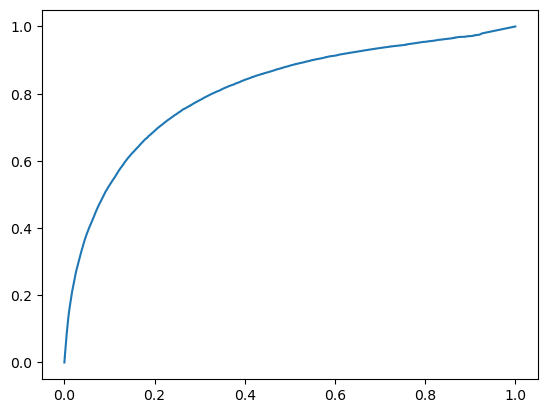

In [11]:
predict_proba=rdf.predict_proba(X_test)
tpr,fpr,thresholds=roc_curve(Y_test,predict_proba[:,1])
#predict_proba2=rdf_2.predict_proba(X_test2)
#tpr2,fpr2,thresholds2=roc_curve(Y_test2,predict_proba2[:,1])
plt.plot(tpr,fpr)

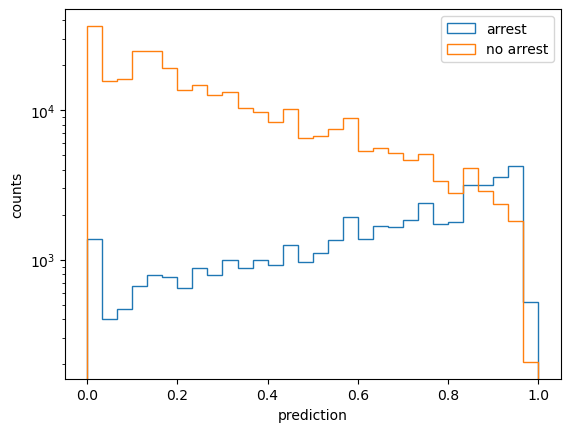

In [12]:
plt.hist((predict_proba[:,1])[Y_test==1],bins=30,histtype='step',label='arrest')
plt.hist((predict_proba[:,1])[Y_test==0],bins=30,histtype='step',label='no arrest')
plt.ylabel('counts')
plt.xlabel('prediction')
plt.legend()
plt.yscale('log')
plt.savefig('distribution_rdf.pdf')

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier
HGC=HistGradientBoostingClassifier(categorical_features=[True,True,True],class_weight='balanced')
HGC.fit(X_train,Y_train)
predict_HGC=HGC.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,predict_HGC)

0.8323484030681745

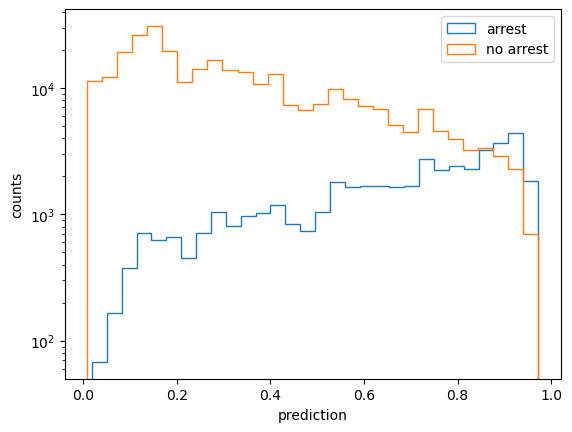

In [14]:
plt.hist((predict_HGC)[Y_test==1],bins=30,histtype='step',label='arrest')
plt.hist((predict_HGC)[Y_test==0],bins=30,histtype='step',label='no arrest')
plt.ylabel('counts')
plt.xlabel('prediction')
plt.legend()
plt.yscale('log')

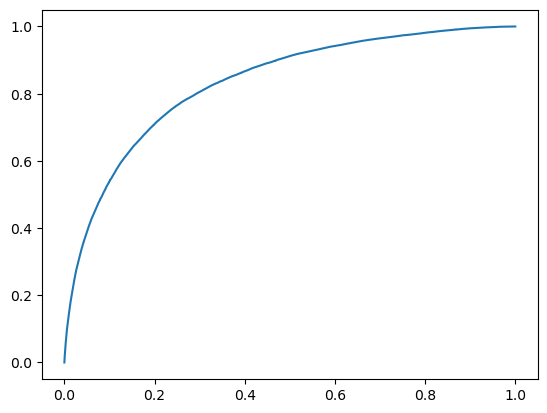

In [15]:
tpr_HGC,fpr_HGC,thresholds_HGC=roc_curve(Y_test,predict_HGC)
plt.plot(tpr_HGC,fpr_HGC)

In [16]:
#opti=tf.keras.optimizers.Adam(learning_rate=5*10**(-6))
#embed_model.compile(loss='binary_crossentropy',optimizer=opti,metrics=['accuracy','precision','AUC'])
class_weights_embed=compute_class_weight(class_weight='balanced',classes=np.unique(Y_train_embed),y=Y_train_embed)
class_weight_dict_embed = dict(enumerate(class_weights_embed))
class_weight_dict_embed

{0: 0.5733099035928432, 1: 3.9101804496767345}

In [17]:
from tensorflow.keras.callbacks import Callback
class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a, p, AUC = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a
        logs['train_precision'] = p
        logs['train_AUC'] = AUC

In [18]:
X_test_random=X_test_embed.copy()
print(X_test_random)
X_test_random['Victim Age']=np.random.uniform(0,99,np.size(X_test_random['Victim Age']))
unnötig,test_random_ages=set_features(X_train_embed,X_test_random)
test_random_ages

         DR Number  Time Occurred  Area ID  Reporting District  Crime Code  \
1239698  160324856           2000        3                 359         480   
1186339  152010187           1600       20                2033         420   
687145   121908273            130       19                1963         745   
1497089  171409100           1400       14                1452         330   
896171   141214707           1310       12                1211         310   
...            ...            ...      ...                 ...         ...   
527661   120218770            900        2                 205         310   
1005879  150204734            950        2                 269         624   
618143   121213396           1615       12                1283         330   
165255   101810441           1020       18                1863         624   
131799   101427619           1000       14                1434         310   

         Victim Age  Premise Code  \
1239698        21.0       

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.05166426e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.44102609e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.96930810e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.46392502e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.55560074e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.52506883e-04]])

In [135]:
def model_build(hp):
    hyper_model=Sequential()
    #units=hp.Int('units',min_value=8,max_value=138,step=16)
    units=hp.Choice('units',[8,16,64,128,256,512])
    drop=hp.Choice('dropout',[0.1,0.2,0.3,0.4])
    #lr=hp.Choice('learning_rate',[10**(-3),10**(-4),10**(-5)])
    #depth=hp.Int('depth',min_value=3,max_value=8,step=1)
    depth=hp.Choice('depth',[3,4,5,6,7,8])
    batch=hp.Choice('Batch Normalization',[0,1])
    hyper_model.add(Dense(units=units, activation='elu', input_dim=1644))
    hyper_model.add(Dropout(drop))
    if batch==1:
        hyper_model.add(tf.keras.layers.BatchNormalization())
    for i in range(depth):
        if units>4:
            units=int(units/2)
        hyper_model.add(Dense(units=units, activation='elu'))
        hyper_model.add(Dropout(drop))
        if batch==1:
            hyper_model.add(tf.keras.layers.BatchNormalization())
    hyper_model.add(Dense(units=1, activation='sigmoid'))
    hyper_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**(-6)),loss='binary_crossentropy',metrics=['accuracy','precision','AUC'])
    return hyper_model

In [136]:
hp_tuner=kt.RandomSearch(model_build,objective='val_AUC',max_trials=25,project_name='Tuning_batch_RandomSearch_halved2')
hp_tuner.search(Code_embed,np.array(Y_train_embed),validation_split=0.3,epochs=5,batch_size=64,class_weight=class_weight_dict_embed,callbacks=[tf.keras.callbacks.TensorBoard(log_dir='RandomSearch_halved_tuning2/logs')])

Trial 25 Complete [00h 05m 04s]
val_AUC: 0.8118925094604492

Best val_AUC So Far: 0.8216362595558167
Total elapsed time: 00h 47m 23s


In [138]:
best_params=hp_tuner.get_best_hyperparameters(num_trials=1)[0]

In [19]:
model_optimized=Sequential()
#model_optimized.add(Dense(units=104, activation='elu', input_dim=1643))
#model_optimized.add(Dense(units=104, activation='elu'))
#model_optimized.add(Dropout(0.1))
#model_optimized.add(Dense(units=104, activation='elu'))
#model_optimized.add(Dropout(0.1))
#model_optimized.add(Dense(units=104, activation='elu'))
#model_optimized.add(Dropout(0.1))
#model_optimized.add(Dense(units=104, activation='elu'))
#model_optimized.add(Dropout(0.1))
#model_optimized.add(Dense(units=1, activation='sigmoid'))
model_optimized.add(Dense(units=256, activation='elu', input_dim=1644))
model_optimized.add(Dropout(0.2))
model_optimized.add(tf.keras.layers.BatchNormalization())
model_optimized.add(Dense(units=128, activation='elu'))
model_optimized.add(Dropout(0.1))
model_optimized.add(tf.keras.layers.BatchNormalization())
model_optimized.add(Dense(units=64, activation='elu'))
model_optimized.add(Dropout(0.1))
model_optimized.add(tf.keras.layers.BatchNormalization())
model_optimized.add(Dense(units=32, activation='elu'))
model_optimized.add(Dropout(0.1))
model_optimized.add(tf.keras.layers.BatchNormalization())
#model_optimized.add(Dense(units=256, activation='elu'))
#model_optimized.add(Dropout(0.2))
#model_optimized.add(tf.keras.layers.BatchNormalization())
#model_optimized.add(Dense(units=256, activation='elu'))
#model_optimized.add(Dropout(0.1))
model_optimized.add(Dense(units=1, activation='sigmoid'))
model_optimized.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**(-6)),loss='binary_crossentropy',metrics=['accuracy','precision','AUC'])


/Users/leanderflottau/miniforge3/envs/IceCube/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
#optimized_hist=model_optimized.fit(Code_embed,np.array(Y_train_embed),validation_split=0.3,epochs=40,batch_size=64,class_weight=class_weight_dict_embed,callbacks=[HistoryEpoch((Code_embed,np.array(Y_train_embed)))])
optimized_hist=model_optimized.fit(Code_embed_train,np.array(Y_embed_train),validation_data=(Code_embed_val,np.array(Y_embed_val)),epochs=35,batch_size=64,class_weight=class_weight_dict_embed,callbacks=[HistoryEpoch((Code_embed_train,np.array(Y_embed_train)))])

Epoch 1/35
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - AUC: 0.6266 - accuracy: 0.5428 - loss: 0.7134 - precision: 0.1681 - val_AUC: 0.7902 - val_accuracy: 0.6270 - val_loss: 0.6877 - val_precision: 0.2306 - train_loss: 0.6891 - train_accuracy: 0.6260 - train_precision: 0.2311 - train_AUC: 0.7917
Epoch 2/35
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.7531 - accuracy: 0.6370 - loss: 0.6015 - precision: 0.2249 - val_AUC: 0.8048 - val_accuracy: 0.6763 - val_loss: 0.6265 - val_precision: 0.2555 - train_loss: 0.6271 - train_accuracy: 0.6755 - train_precision: 0.2558 - train_AUC: 0.8071
Epoch 3/35
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.7734 - accuracy: 0.6764 - loss: 0.5786 - precision: 0.2472 - val_AUC: 0.8111 - val_accuracy: 0.6962 - val_loss: 0.5961 - val_precision: 0.2671 - train_loss: 0.5963 - train_accuracy: 0.6958 - train_precision: 0.2676 - train_AUC: 0.8139
Epoch 4/35
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.7837 - accuracy: 0.6962 - loss: 0.5662 

In [38]:
optimized_pred=model_optimized.predict(Onehot_test)
randomized_pred=model_optimized.predict(test_random_ages)
roc_auc_score(Y_test_embed,optimized_pred)

10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 441us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 428us/step


0.8328133949801726

In [39]:
model_optimized.evaluate(Onehot_test,np.array(Y_test_embed))

10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 498us/step - AUC: 0.8326 - accuracy: 0.7489 - loss: 0.5128 - precision: 0.3051


[0.5128933787345886,
 0.7491945624351501,
 0.30629897117614746,
 0.8328064680099487]

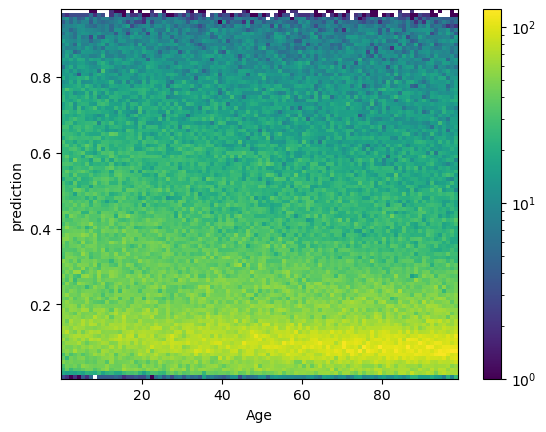

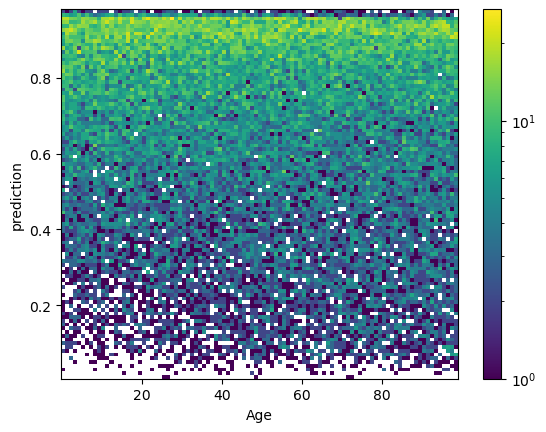

Text(0.5, 0, 'Age')

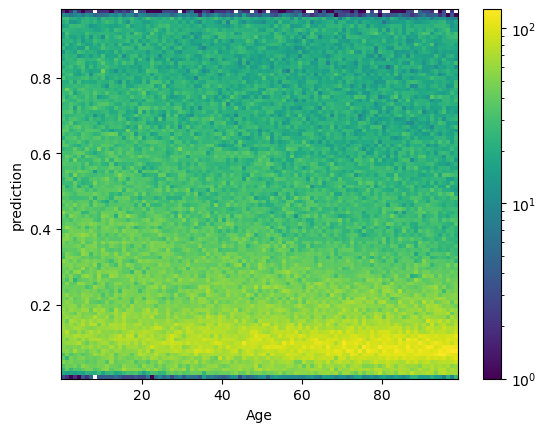

In [40]:
plt.hist2d((X_test_random['Victim Age'])[Y_test_embed==0],(randomized_pred[:,0])[Y_test_embed==0],bins=99,norm='log')
plt.colorbar()
plt.ylabel('prediction')
plt.xlabel('Age')
plt.show()
plt.hist2d((X_test_random['Victim Age'])[Y_test_embed==1],(randomized_pred[:,0])[Y_test_embed==1],bins=99,norm='log')
plt.colorbar()
plt.ylabel('prediction')
plt.xlabel('Age')
plt.show()
plt.hist2d((X_test_random['Victim Age']),(randomized_pred[:,0]),bins=99,norm='log')
plt.colorbar()
plt.ylabel('prediction')
plt.xlabel('Age')
#plt.hist2d((X_test_random['Victim Age'])[Y_test_embed==0],(predict_proba[:,1])[Y_test_embed==0],bins=99,norm='log')

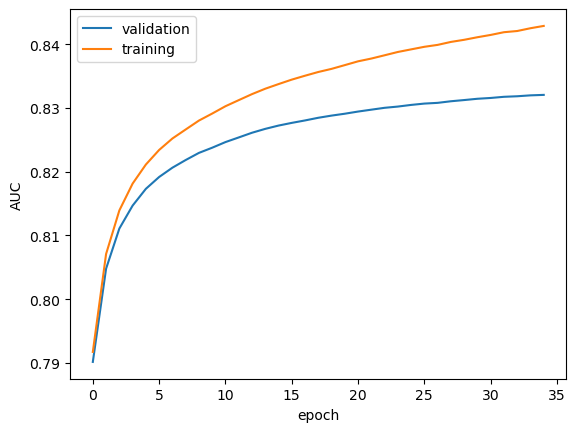

In [41]:
#plt.plot(range(20),embed_hist.history['val_AUC'],label='high lr AUC validation')
#plt.plot(range(20),embed_hist.history['AUC'],label='high lr AUC test')
plt.plot(range(35),optimized_hist.history['val_AUC'],label='validation')
plt.plot(range(35),optimized_hist.history['train_AUC'],label='training')
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.legend()

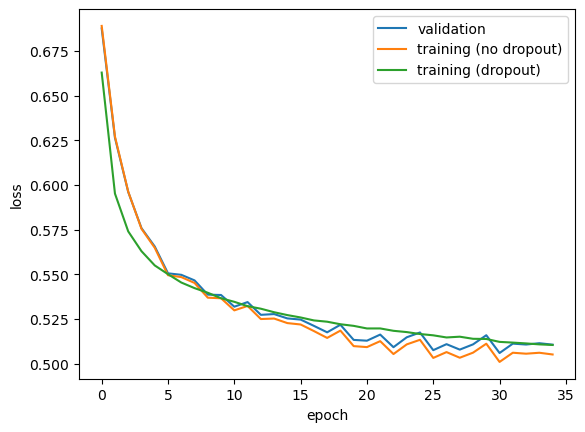

In [42]:
plt.plot(range(35),optimized_hist.history['val_loss'],label='validation')
plt.plot(range(35),optimized_hist.history['train_loss'],label='training (no dropout)')
plt.plot(range(35),optimized_hist.history['loss'],label='training (dropout)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

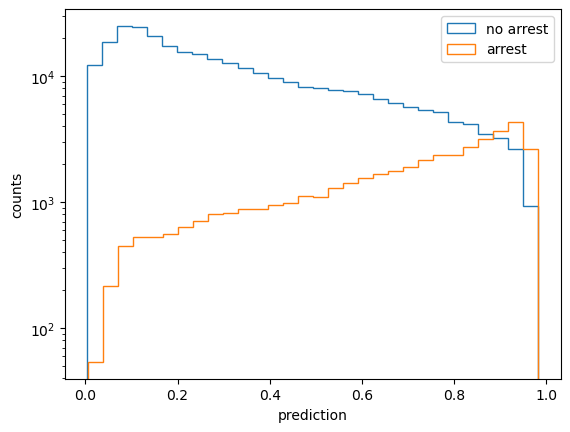

In [43]:
plt.hist(optimized_pred[Y_test_embed==0],bins=30,histtype='step',label='no arrest')
plt.hist(optimized_pred[Y_test_embed==1],bins=30,histtype='step',label='arrest')
plt.xlabel('prediction')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

0.8328133949801726


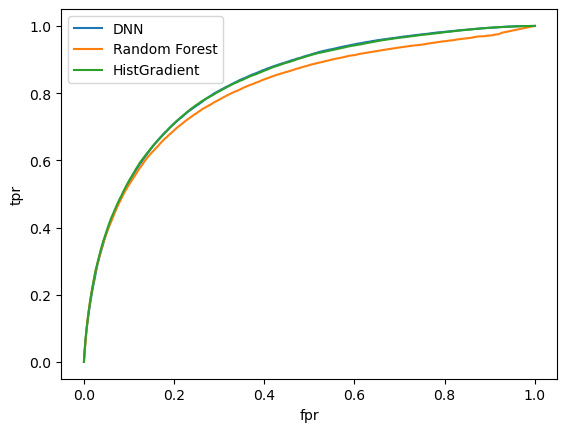

In [44]:
tpr_oh,fpr_oh,th_oh=roc_curve(Y_test_embed,optimized_pred)
plt.plot(tpr_oh,fpr_oh,label='DNN')
plt.plot(tpr,fpr,label='Random Forest')
plt.plot(tpr_HGC,fpr_HGC,label='HistGradient')
print(roc_auc_score(Y_test_embed,optimized_pred))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

0.8328374338547776


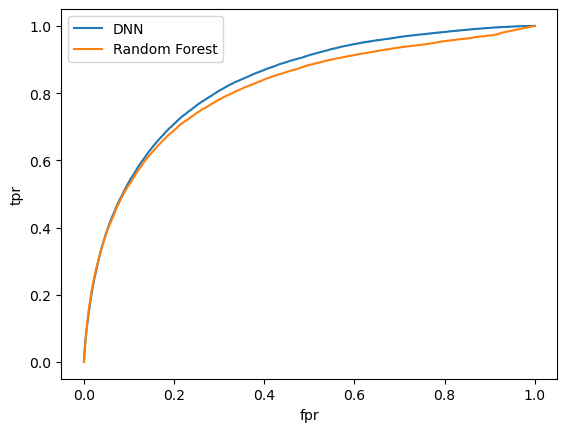

In [37]:
tpr_oh,fpr_oh,th_oh=roc_curve(Y_test_embed,optimized_pred)
plt.plot(tpr_oh,fpr_oh,label='DNN')
plt.plot(tpr,fpr,label='Random Forest')
#plt.plot(tpr_HGC,fpr_HGC,label='HistGradient')
print(roc_auc_score(Y_test_embed,optimized_pred))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

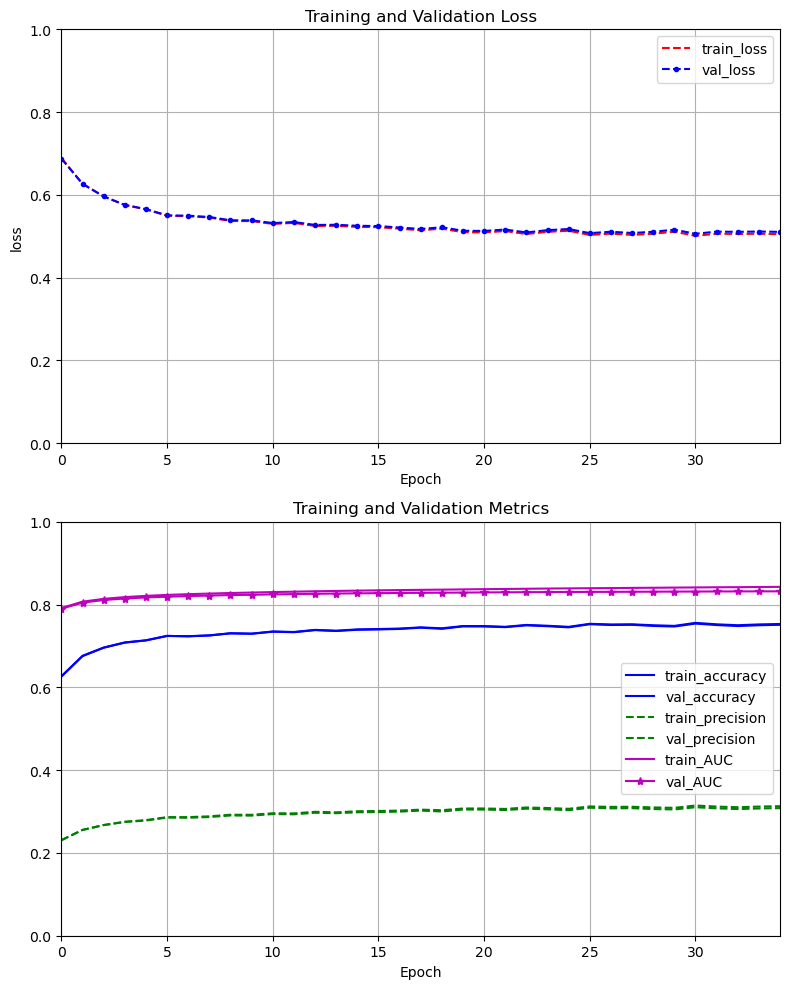

In [45]:
# Assuming embed_hist.history is a dictionary containing the training history
history_dataframe = optimized_hist.history

# Create a DataFrame from the history dictionary
df = pd.DataFrame(history_dataframe)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot the loss curves in the first subplot
df[['train_loss', 'val_loss']].plot(
    ax=ax[0],
    xlim=[0, 34], 
    ylim=[0, 1], 
    grid=True, 
    ylabel = "loss",
    xlabel="Epoch",
    style=["r--", "b--."]
)
ax[0].set_title('Training and Validation Loss')

# Plot the other metrics (e.g., accuracy, precision, AUC) in the second subplot
df[['train_accuracy', 'val_accuracy', 'train_precision', 'val_precision', 'train_AUC', 'val_AUC']].plot(
    ax=ax[1],
    xlim=[0, 34], 
    ylim=[0, 1], 
    grid=True, 
    xlabel="Epoch",
    style=["b-", "b-", "g--", "g--", "m-", "m-*"]
)
ax[1].set_title('Training and Validation Metrics')

# Display the plots
plt.tight_layout()
plt.show()

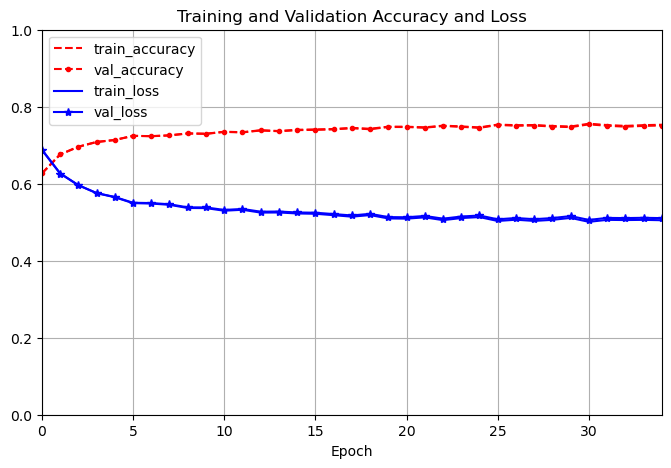

In [46]:
history = optimized_hist.history
df = pd.DataFrame(history)

df[['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss']].plot(
    figsize=(8, 5), xlim=[0, 34], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], title="Training and Validation Accuracy and Loss"
)
plt.show() 

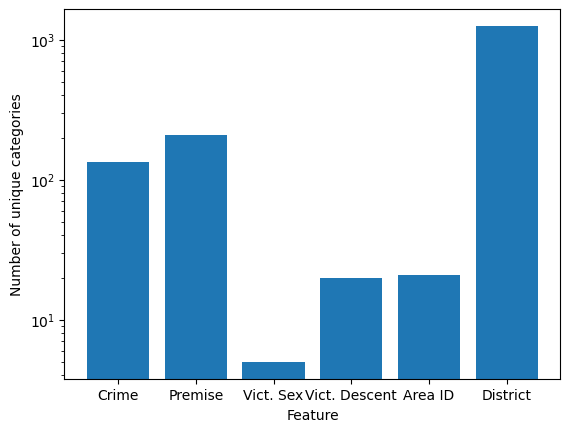

In [62]:
uniques=np.array([len(set(merged_embed['Crime Code Description'])),len(set(merged_embed['Premise Description'])),len(set(merged_embed['Victim Sex'])),len(set(merged_embed['Victim Descent'])),len(set(merged_embed['Area ID'])),len(set(merged_embed['Reporting District']))])
categoricals=['Crime','Premise','Vict. Sex','Vict. Descent','Area ID','District']
plt.bar(categoricals,uniques)
plt.xlabel('Feature')
plt.ylabel('Number of unique categories')
plt.yscale('log')
plt.savefig('Unique_Categories.pdf')

In [ ]:
len(set(merged_embed['Reporting District']))

1253

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
skf=StratifiedKFold(n_splits=4,shuffle=True)
AUC=np.zeros((4,2))
#acc=np.zeros((4,2))
train_loss=np.zeros((4,15))
val_loss=np.zeros((4,15))
train_AUC=np.zeros((4,15))
val_AUC=np.zeros((4,15))
merged_shuffled=shuffle(merged_embed)
X_cv=merged_shuffled.drop('arrest',axis=1)
Y_cv=merged_shuffled['arrest']
#print(X_cv.head())
for k_index, (train_idx, test_idx) in enumerate(skf.split(X,Y)):
    #print(k_index)
    x_cv_train=X_cv.iloc[train_idx]
    x_cv_test=X_cv.iloc[test_idx]
    y_cv_train=Y_cv.iloc[train_idx]
    y_cv_test=Y_cv.iloc[test_idx]
    #print(x_cv_train)
    class_weights_cv=compute_class_weight(class_weight='balanced',classes=np.unique(y_cv_train),y=y_cv_train)
    class_weight_cv = dict(enumerate(class_weights_cv))
    #print(x_cv_train)
    x_cv_train,x_cv_test=set_features(x_cv_train,x_cv_test)
    #print(class_weight_cv)
    #print(x_cv_train)
    #print(np.array(y_cv_test))
    model_cv=Sequential()
    model_cv.add(Dense(units=256, activation='elu', input_dim=1644))
    model_cv.add(Dropout(0.2))
    model_cv.add(tf.keras.layers.BatchNormalization())
    model_cv.add(Dense(units=128, activation='elu', input_dim=1644))
    model_cv.add(Dropout(0.2))
    model_cv.add(tf.keras.layers.BatchNormalization())
    model_cv.add(Dense(units=64, activation='elu', input_dim=1644))
    model_cv.add(Dropout(0.2))
    model_cv.add(tf.keras.layers.BatchNormalization())
    model_cv.add(Dense(units=32, activation='elu', input_dim=1644))
    model_cv.add(Dropout(0.2))
    model_cv.add(tf.keras.layers.BatchNormalization())
    model_cv.add(Dense(units=1, activation='sigmoid'))
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**(-6)),loss='binary_crossentropy',metrics=['accuracy','precision','AUC'])
    cv_history=model_cv.fit(x_cv_train,np.array(y_cv_train),validation_split=0.3,epochs=15,batch_size=64,class_weight=class_weight_cv,callbacks=[HistoryEpoch((x_cv_train,np.array(y_cv_train)))])
    cv_pred=model_cv.predict(x_cv_test)
    AUC[k_index,0]=roc_auc_score(y_cv_test,cv_pred)
    AUC[k_index,1]=(cv_history.history['train_AUC'])[-1]
    train_loss[k_index,:]=cv_history.history['loss'] 
    val_loss[k_index,:]=cv_history.history['val_loss']
    train_AUC[k_index,:]=cv_history.history['AUC']
    val_AUC[k_index,:]=cv_history.history['val_AUC']

/Users/leanderflottau/miniforge3/envs/IceCube/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - AUC: 0.5999 - accuracy: 0.5369 - loss: 0.7726 - precision: 0.1599 - val_AUC: 0.7904 - val_accuracy: 0.6773 - val_loss: 0.6270 - val_precision: 0.2512 - train_loss: 0.6273 - train_accuracy: 0.6767 - train_precision: 0.2519 - train_AUC: 0.7917
Epoch 2/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - AUC: 0.7311 - accuracy: 0.6266 - loss: 0.6338 - precision: 0.2147 - val_AUC: 0.8039 - val_accuracy: 0.7033 - val_loss: 0.5870 - val_precision: 0.2680 - train_loss: 0.5869 - train_accuracy: 0.7034 - train_precision: 0.2694 - train_AUC: 0.8059
Epoch 3/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - AUC: 0.7565 - accuracy: 0.6633 - loss: 0.6018 - precision: 0.2346 - val_AUC: 0.8096 - val_accuracy: 0.7179 - val_loss: 0.5596 - val_precision: 0.2779 - train_loss: 0.5593 - train_accuracy: 0.7179 - train_precision: 0.2794 - train_AUC: 0.8120
Epoch 4/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - AUC: 0.7685 - accuracy: 0.6809 - loss: 0.5879 

/Users/leanderflottau/miniforge3/envs/IceCube/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - AUC: 0.6234 - accuracy: 0.5484 - loss: 0.7505 - precision: 0.1675 - val_AUC: 0.7895 - val_accuracy: 0.6676 - val_loss: 0.6459 - val_precision: 0.2475 - train_loss: 0.6453 - train_accuracy: 0.6681 - train_precision: 0.2481 - train_AUC: 0.7907
Epoch 2/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - AUC: 0.7301 - accuracy: 0.6325 - loss: 0.6374 - precision: 0.2171 - val_AUC: 0.8030 - val_accuracy: 0.6991 - val_loss: 0.6023 - val_precision: 0.2670 - train_loss: 0.6017 - train_accuracy: 0.6991 - train_precision: 0.2674 - train_AUC: 0.8045
Epoch 3/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - AUC: 0.7532 - accuracy: 0.6679 - loss: 0.6084 - precision: 0.2372 - val_AUC: 0.8094 - val_accuracy: 0.7187 - val_loss: 0.5687 - val_precision: 0.2799 - train_loss: 0.5682 - train_accuracy: 0.7183 - train_precision: 0.2800 - train_AUC: 0.8112
Epoch 4/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - AUC: 0.7663 - accuracy: 0.6865 - loss: 0.5923 

/Users/leanderflottau/miniforge3/envs/IceCube/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - AUC: 0.6103 - accuracy: 0.5439 - loss: 0.7861 - precision: 0.1645 - val_AUC: 0.7896 - val_accuracy: 0.6742 - val_loss: 0.6391 - val_precision: 0.2499 - train_loss: 0.6393 - train_accuracy: 0.6739 - train_precision: 0.2511 - train_AUC: 0.7915
Epoch 2/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - AUC: 0.7251 - accuracy: 0.6245 - loss: 0.6453 - precision: 0.2118 - val_AUC: 0.8028 - val_accuracy: 0.7062 - val_loss: 0.5916 - val_precision: 0.2700 - train_loss: 0.5916 - train_accuracy: 0.7058 - train_precision: 0.2710 - train_AUC: 0.8052
Epoch 3/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - AUC: 0.7525 - accuracy: 0.6621 - loss: 0.6097 - precision: 0.2334 - val_AUC: 0.8085 - val_accuracy: 0.7100 - val_loss: 0.5825 - val_precision: 0.2735 - train_loss: 0.5824 - train_accuracy: 0.7098 - train_precision: 0.2748 - train_AUC: 0.8112
Epoch 4/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - AUC: 0.7639 - accuracy: 0.6816 - loss: 0.5949 

/Users/leanderflottau/miniforge3/envs/IceCube/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - AUC: 0.6190 - accuracy: 0.5462 - loss: 0.7960 - precision: 0.1673 - val_AUC: 0.7885 - val_accuracy: 0.6761 - val_loss: 0.6253 - val_precision: 0.2511 - train_loss: 0.6258 - train_accuracy: 0.6763 - train_precision: 0.2517 - train_AUC: 0.7900
Epoch 2/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - AUC: 0.7253 - accuracy: 0.6251 - loss: 0.6455 - precision: 0.2120 - val_AUC: 0.8022 - val_accuracy: 0.7031 - val_loss: 0.5875 - val_precision: 0.2685 - train_loss: 0.5880 - train_accuracy: 0.7027 - train_precision: 0.2691 - train_AUC: 0.8041
Epoch 3/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - AUC: 0.7509 - accuracy: 0.6616 - loss: 0.6140 - precision: 0.2337 - val_AUC: 0.8082 - val_accuracy: 0.7131 - val_loss: 0.5675 - val_precision: 0.2759 - train_loss: 0.5678 - train_accuracy: 0.7127 - train_precision: 0.2764 - train_AUC: 0.8103
Epoch 4/15
9498/9498 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - AUC: 0.7650 - accuracy: 0.6821 - loss: 0.5931 

Text(0, 0.5, 'AUC')

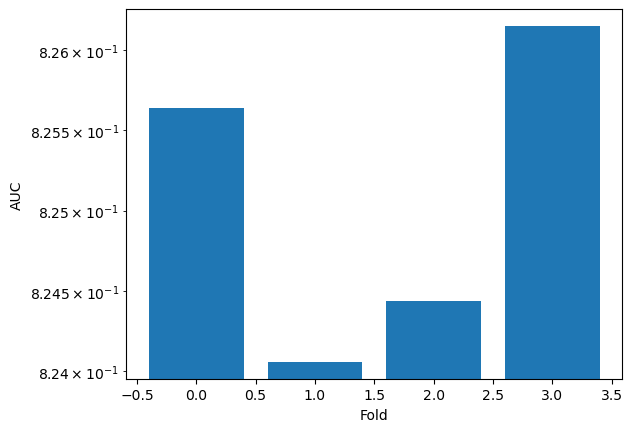

In [38]:
plt.bar(range(4),AUC[:,0])
plt.yscale('log')
plt.xlabel('Fold')
plt.ylabel('AUC')

In [39]:
print(np.mean(AUC[:,0]))
print(np.std(AUC[:,0]))
print(AUC)

0.8250721512368868
0.0008533453317519031
[[0.82563978 0.82925338]
 [0.82405933 0.82821059]
 [0.82443868 0.82786047]
 [0.82615081 0.82903063]]


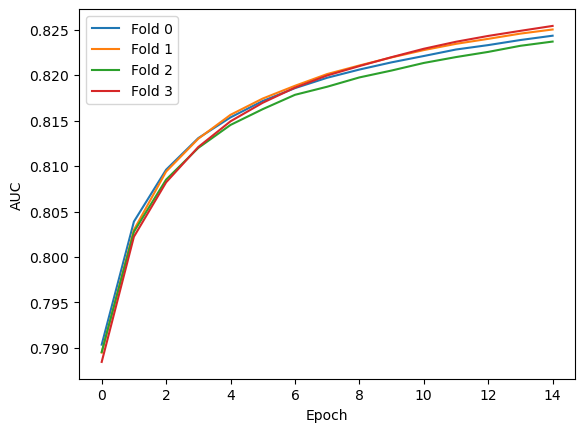

In [41]:
plt.plot(range(15),val_AUC[0,:],label='Fold 0')
plt.plot(range(15),val_AUC[1,:],label='Fold 1')
plt.plot(range(15),val_AUC[2,:],label='Fold 2')
plt.plot(range(15),val_AUC[3,:],label='Fold 3')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

In [55]:
relevant_features=['Area ID', 'Crime Code Description', 'Premise Description', 'Victim Age', 'Victim Descent', 'Time Occurred', 'Days Between', 'Reporting District','Victim Sex']
#relevant_features=['Victim Age']
Relevance=np.zeros(np.size(relevant_features))
#age_diffference=np.zeros((1,np.size(optimized_pred)))
k=0
for i in relevant_features:
    shuffled_testing=X_test_embed.copy()
    shuffled_testing[i]=np.array(shuffle(shuffled_testing[i]))
    unnötig2, shuffled_testing_onehot=set_features(X_train_embed,shuffled_testing)
    shuffled_prediction=model_optimized.predict(shuffled_testing_onehot)
    #print(shuffled_testing[i])
    #print(X_)
    if i=='Victim Age':
        age_difference=np.array(shuffled_testing[i]-X_test_embed[i])
        prediction_difference=shuffled_prediction-optimized_pred
    Relevance[k]=np.sqrt(np.mean(((optimized_pred)[shuffled_testing[i]!=X_test_embed[i]]-(shuffled_prediction)[shuffled_testing[i]!=X_test_embed[i]])**2))
    k+=1

10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 426us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 427us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 428us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 426us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 429us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 428us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 429us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 430us/step
10854/10854 ━━━━━━━━━━━━━━━━━━━━ 5s 429us/step


In [56]:
Relevance

array([0.07887245, 0.36489958, 0.16124582, 0.02914402, 0.04178375,
       0.02393479, 0.        , 0.07098585, 0.04246386])

Text(0, 0.5, 'prediction difference')

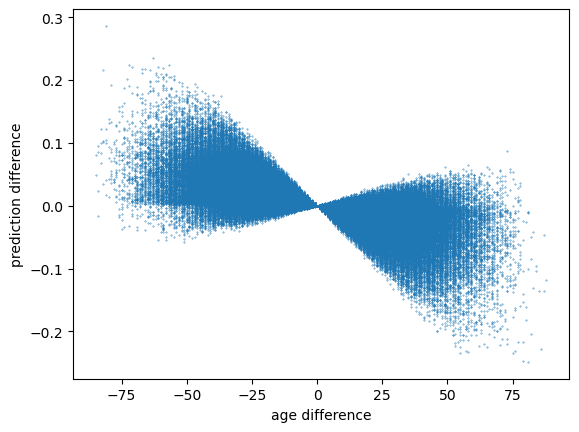

In [58]:
#print(pred_diff)
#print(age_diff)
plt.scatter(age_difference,prediction_difference,s=0.1)
plt.xlabel('age difference')
plt.ylabel('prediction difference')

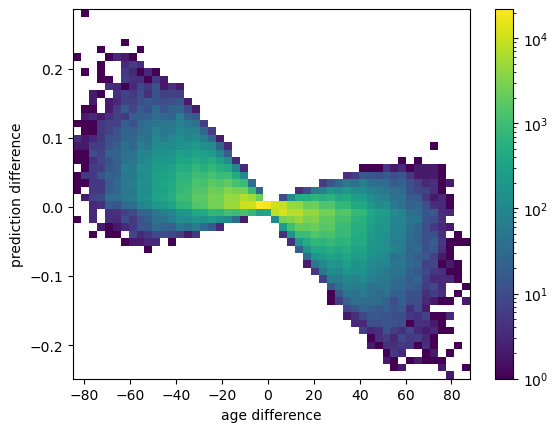

In [59]:
plt.hist2d(age_difference,prediction_difference[:,0],bins=50,cmin=1,norm='log')
plt.xlabel('age difference')
plt.ylabel('prediction difference')
plt.colorbar()

In [35]:
np.size((merged_embed['arrest'])[merged_embed['arrest']==1])/np.size(merged_embed['arrest'])

0.12773062209511735

In [85]:
merged_embed['Premise Description'].max()

'YARD (RESIDENTIAL/BUSINESS)'

In [83]:
pred_diff

array([[-0.00040765],
       [-0.02470024],
       [ 0.00199109],
       ...,
       [-0.00467005],
       [ 0.02635399],
       [-0.02252054]], dtype=float32)

In [89]:
(X_test_embed['Crime Code Description'])[pred_diff[:,0]>0.04].max()

'WEAPONS POSSESSION/BOMBING'

In [97]:
(X_test_embed['Premise Description'])[optimized_pred[:,0]>0.9].max()

'YARD (RESIDENTIAL/BUSINESS)'

Text(0, 0.5, 'MSE')

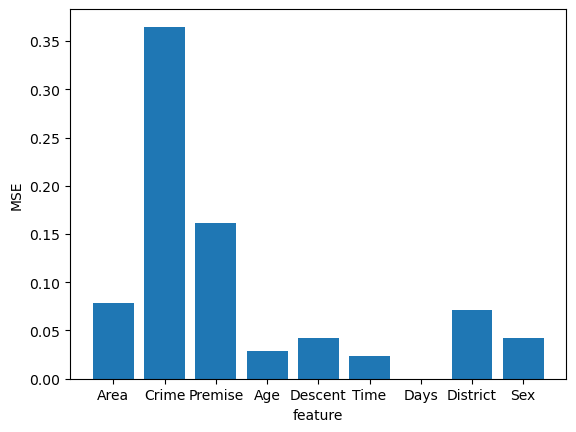

In [57]:
plt.bar(['Area','Crime','Premise','Age','Descent','Time','Days','District','Sex'],Relevance)
plt.xlabel('feature')
plt.ylabel('MSE')

In [30]:
shuffled_prediction

array([[0.10036472],
       [0.11938919],
       [0.30695552],
       ...,
       [0.10847907],
       [0.47731197],
       [0.21016896]], dtype=float32)

In [61]:
pd.__version__

'2.2.2'

In [37]:
optimized_pred

array([[0.09434645],
       [0.05618045],
       [0.24849491],
       ...,
       [0.06877212],
       [0.496441  ],
       [0.24983843]], dtype=float32)

In [101]:
merged_embed[relevant_features].head()

,Area ID,Crime Code Description,Premise Description,Victim Age,Victim Descent,Time Occurred,Days Between,Reporting District,Victim Sex
4,21,VANDALISM - MISDEAMEANOR ($399 OR UNDER),SINGLE FAMILY DWELLING,84.0,W,2300,7,2133,M
9,9,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)",OTHER BUSINESS,27.0,O,800,73,904,F
12,12,THEFT PLAIN - PETTY ($950 & UNDER),PARKING LOT,42.0,H,1200,9,1266,M
14,15,SHOPLIFTING - PETTY THEFT ($950 & UNDER),DEPARTMENT STORE,12.0,O,2030,0,1511,M
15,18,INTIMATE PARTNER - SIMPLE ASSAULT,SINGLE FAMILY DWELLING,19.0,H,500,1,1823,F
